UNIVERSIDAD GALILEO

STATISTICAL LEARNING II

Marco Vinicio Escalante Lara

Carné: **19001148**

# RED NEUORONAL CONVOLUCIONAL (CNN)

El presente trabajo se baso en el código utilizado para crear un programa que imitara la textura de una imagen sobre otra, adjunto el link de la página.

http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style

In [1]:
# Importamos las librerias que vamos a utilizar en el programa
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import imageio
import tensorflow as tf  # Import TensorFlow after Scipy or Scipy will break
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

/home/marco/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marco/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marco/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/marco/anaconda3/lib/python3.7/site-packages/tensorboard/co

Definimos la dirección de salida de nuestras imagenes, así como la imagen de estilo, que para este caso se trata de un dibujo de mickey mouse en sepia como que fuera dibujado a mano y la imagen de goku haciendo una genkidama, ambas imagenes con dimensiones de 800 x 600

In [2]:
OUTPUT_DIR = 'output/'

STYLE_IMAGE = 'images/mouse.jpg'

CONTENT_IMAGE = 'images/goku.jpg'

IMAGE_WIDTH = 800
IMAGE_HEIGHT = 600
COLOR_CHANNELS = 3

Definimos algunas constantes que vamos a emplear para nuestro modelo

In [3]:
# Colocamos el porcentaje de blur o ruido que queremos que tenga nuestra imagen
NOISE_RATIO = 0.6
# Es la constante que define que tanto enfasis tendra el contenido de la imagen, en este caso Goku
BETA = 5
# Es la constante que define que tanto enfasis tentra el estilo de la imagen, en esta caso Mikey mouse
ALPHA = 100
# Tomamos los datos de un repositorio que contiene los datos necesario para poder generar nuestra red,
# en este caso el archivo pesa 500MB y se encuentra para descargar en el siguiente link
# http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style con el nombre VGG-19 model
VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'
# Obtenemos la media de los datos que nos permitiran saber en que rango de datos se encuentra nuestra información.
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

Definimos el modelo que tiene como proposito generar el grafo, por medio de TF, que nos permita cambiar nuestra imagen combinando nuestras dos graficas que propusimos.

In [4]:
def load_vgg_model(path):
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    # Determinamos nuestras matrices de pesos.

    def _weights(layer, expected_layer_name):
        # Pesos de las variables
        W = vgg_layers[0][layer][0][0][2][0][0]
        # Bias
        b = vgg_layers[0][layer][0][0][2][0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        print({'layer name':layer_name, 'expected_layer_name':expected_layer_name})
        assert layer_name == expected_layer_name
        return W, b
    
    # Nuestra función de activación que para el caso en particular se trata de relu
    def _relu(conv2d_layer):
        return tf.compat.v1.nn.relu(conv2d_layer)
    
    # Definimos la convolución de nuestra imagen
    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.compat.v1.constant(W)
        b = tf.compat.v1.constant(np.reshape(b, (b.size)))
        return tf.compat.v1.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b
    
    # Definimos la convolución y la función de activación de nuestra imagen en conjunto
    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    # Colocamos, tanto los ksize, strides y padding de nuestra convolución
    def _avgpool(prev_layer):
        return tf.compat.v1.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

   # Se construye el grafo de nuestra red, con el apoyo de Tensorflow.
    graph = {}
    graph['input']   = tf.compat.v1.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

Definimos la función de perdida de contenido para nuestras imagenes

In [5]:
def content_loss_func(sess, model):
    def _content_loss(p, x):
        # Definimos el número de filtros.
        N = p.shape[3]
        # Definimos el peso de los filtros en el espacio
        M = p.shape[1] * p.shape[2]
        # Para el caso en particular de nuestras imagenes se utilizara la siguiente función:
        # 0.5 * tf.reduce_sum(tf.pow(x - p, 2)) 
        # Esta función emplearemos para pintar nuestra imagen, pero presenta como caracteristias 
        # su lentitud para hace la misma.
        return (1 / (4 * N * M)) * tf.compat.v1.reduce_sum(tf.compat.v1.pow(x - p, 2))
    return _content_loss(sess.run(model['conv4_2']), model['conv4_2'])

Definimos de la imagen de estilo, cinco layers a usar, permitiendo aumentar o disminuir e peso de las capas según lo que estamos trabajando.

In [6]:
STYLE_LAYERS = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
]

def style_loss_func(sess, model):
    def _gram_matrix(F, N, M):
        # La matriz de nuestro modelo
        Ft = tf.compat.v1.reshape(F, (M, N))
        return tf.compat.v1.matmul(tf.compat.v1.transpose(Ft), Ft)

    def _style_loss(a, x):
        # El estilo que se propone tome para la función de perdida.
        # N es el número del filtro en la capa 1
        N = a.shape[3]
        # M son las capas de nuestra imagen.
        M = a.shape[1] * a.shape[2]
        # A es el estilo de representación de la imagen original.
        A = _gram_matrix(a, N, M)
        # G es el estilo de la imagen modificada.
        G = _gram_matrix(x, N, M)
        result = (1 / (4 * N**2 * M**2)) * tf.compat.v1.reduce_sum(tf.compat.v1.pow(G - A, 2))
        return result

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss

Vamos a generar nuestras imagenes con ruido, para facilitar la transferencia de estilos de una a otra.

In [7]:
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    noise_image = np.random.uniform(
            -20, 20,
            (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    # Con los valores colocados inicialmente generamos el "blur" de nuestra imagen.
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

# Fución para cargar nuestra imagen.
def load_image(path):
    image = imageio.imread(path)
    image = np.reshape(image, ((1,) + image.shape))
    image = image - MEAN_VALUES
    return image

# Función para guardar nuestra imagen en la dirección colocada.
def save_image(path, image):
    image = image + MEAN_VALUES
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    imageio.imwrite(path, image)

In [8]:
# Inicializamos nuestras variables que vamos a emplear en el grafo.
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


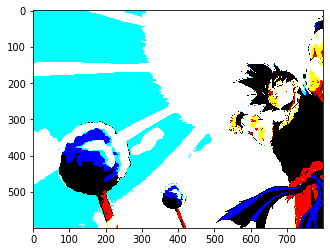

In [9]:
# Mostramos la imgane que vamos a emplear como contenido o base para trabar el estilo de la otra imagen.
content_image = load_image(CONTENT_IMAGE)
imshow(content_image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


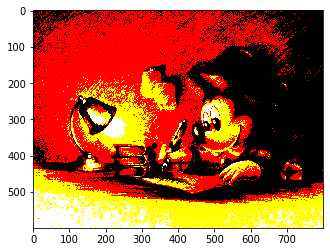

In [10]:
# Mostramos la imagen que tiene como finalidad ser el estilo de la primera.
style_image = load_image(STYLE_IMAGE)
imshow(style_image[0])

Cargamos el modelo que tenemos con todas las caracteristicas de las imagenes en la variable "model" con la finalidad de poder emplearlo en la red neuronal.

In [11]:
model = load_vgg_model(VGG_MODEL)

{'layer name': 'conv1_1', 'expected_layer_name': 'conv1_1'}
{'layer name': 'conv1_2', 'expected_layer_name': 'conv1_2'}
{'layer name': 'conv2_1', 'expected_layer_name': 'conv2_1'}
{'layer name': 'conv2_2', 'expected_layer_name': 'conv2_2'}
{'layer name': 'conv3_1', 'expected_layer_name': 'conv3_1'}
{'layer name': 'conv3_2', 'expected_layer_name': 'conv3_2'}
{'layer name': 'conv3_3', 'expected_layer_name': 'conv3_3'}
{'layer name': 'conv3_4', 'expected_layer_name': 'conv3_4'}
{'layer name': 'conv4_1', 'expected_layer_name': 'conv4_1'}
{'layer name': 'conv4_2', 'expected_layer_name': 'conv4_2'}
{'layer name': 'conv4_3', 'expected_layer_name': 'conv4_3'}
{'layer name': 'conv4_4', 'expected_layer_name': 'conv4_4'}
{'layer name': 'conv5_1', 'expected_layer_name': 'conv5_1'}
{'layer name': 'conv5_2', 'expected_layer_name': 'conv5_2'}
{'layer name': 'conv5_3', 'expected_layer_name': 'conv5_3'}
{'layer name': 'conv5_4', 'expected_layer_name': 'conv5_4'}


Generamos el "blur" de la imagen original para poder realizar la carga de estilo de la imagen que tenemos establecida para lo mismo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


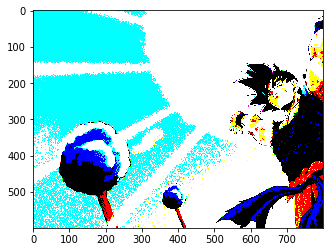

In [12]:
input_image = generate_noise_image(content_image)
imshow(input_image[0])

Corremos nuestro grafo para este caso en particular, el cual estamos empleando 5000 iteraciones

In [13]:
with tf.compat.v1.Session() as sess:
    model = load_vgg_model(VGG_MODEL)
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(model['input'].assign(content_image))
    content_loss = content_loss_func(sess, model)
    sess.run(model['input'].assign(style_image))
    style_loss = style_loss_func(sess, model)
    total_loss = BETA * content_loss + ALPHA * style_loss
    optimizer = tf.compat.v1.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(total_loss)
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    ITERATIONS = 5000
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    for it in range(ITERATIONS):
        sess.run(train_step)
        if it%100 == 0:
            # Print every 100 iteration.
            mixed_image = sess.run(model['input'])
            print('Iteration %d' % (it))
            print('sum : ', sess.run(tf.compat.v1.reduce_sum(mixed_image)))
            print('cost: ', sess.run(total_loss))

            if not os.path.exists(OUTPUT_DIR):
                os.mkdir(OUTPUT_DIR)

            filename = 'output/%d.png' % (it)
            save_image(filename, mixed_image)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
{'layer name': 'conv1_1', 'expected_layer_name': 'conv1_1'}
{'layer name': 'conv1_2', 'expected_layer_name': 'conv1_2'}
{'layer name': 'conv2_1', 'expected_layer_name': 'conv2_1'}
{'layer name': 'conv2_2', 'expected_layer_name': 'conv2_2'}
{'layer name': 'conv3_1', 'expected_layer_name': 'conv3_1'}
{'layer name': 'conv3_2', 'expected_layer_name': 'conv3_2'}
{'layer name': 'conv3_3', 'expected_layer_name': 'conv3_3'}
{'layer name': 'conv3_4', 'expected_layer_name': 'conv3_4'}
{'layer name': 'conv4_1', 'expected_layer_name': 'conv4_1'}
{'layer name': 'conv4_2', 'expected_layer_name': 'conv4_2'}
{'layer name': 'conv4_3', 'expected_layer_name': 'conv4_3'}
{'layer name': 'conv4_4', 'expected_layer_name': 'conv4_4'}
{'layer name': 'conv5_1', 'expected_layer_name': 'conv5_1'}
{'layer name': 'conv5_2', 'expected_layer_name': 'conv5_2'}
{'layer name': 'conv5_3', 'expected_layer_name': 'conv5_3'}
{'layer name': 'con

KeyboardInterrupt: 

### NOTA DEL ERROR

Se tiene el error, ya que yo había dejado correr hasta 5,000 iteraciones y la interrumpi cuando estaba en 3,200 aproximaamente ya que tenía que entregar el proyecto y no podía dejar la maquina corriendo, sin embargo quitando ese incoveniente se puede apreciar que todo funciona correctamente.

### Imagen de la iterción 3,200:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


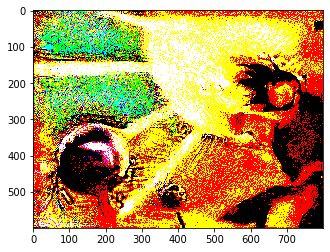

In [19]:
salida = '3200.png'
salida_imagen = load_image(salida)
imshow(salida_imagen[0])

## Conclusiones

Imagen generada, luego de 4 horas y media de correr el programa, como se puede apreciar si se pudo combinar el estilo de la imagen de Mickey mouse con goku, cambiando completamente la imagen original.

Los algoritmos de transferencia funcionan bastante bien, sin embargo consumen muchos recursos, ya que mi maquina se calento y hasta se trabo para poder realizar esta red.

Para tabajar estos proyectos se recomienda realizar un pre procesamiento a las imagenes como fue el caso de hacer blur al mismo.

En si la red consiste en una serie de iteraciones donde se transfiere información de una red a la otra.